In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import KarateClub
import numpy as np
from gensim.models.word2vec import Word2Vec

In [18]:
# Loading the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

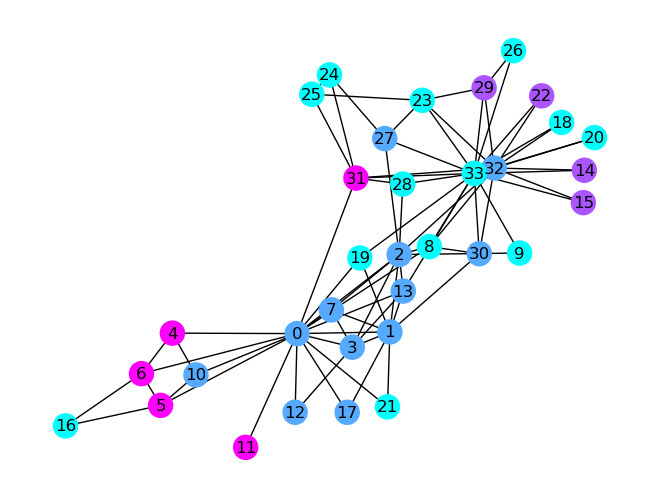

In [19]:
# Visualization of the loaded dataset using NetworkX
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())

labels = data.y.tolist()

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=labels, cmap=plt.get_cmap('cool'))
plt.show()

In [20]:
def randomWalk(start_node, walk_length):
    walk = [start_node]
    for i in range(walk_length):
        neighbors = data.edge_index[1][data.edge_index[0] == walk[-1]]
        walk.append(np.random.choice(neighbors))
    return walk

"At the start of each pass we generate a random ordering to traverse the vertices. This is not strictly required, but is well-known to speed up the convergence of stochastic gradient descent." - DeepWalk: Online Learning of Social Representations

In [21]:
walk_number = 10 # Number of walks performed per vertex
walk_length = 20
vertices = np.arange(data.num_nodes)
walks = []
for i in range(walk_number):
    np.random.shuffle(vertices) 
    for j in vertices:
        walks.append(randomWalk(j, walk_length))

Steps in random walk: [25, 31, 24, 27, 24, 31, 33, 13, 2, 27, 23, 33, 23, 33, 29, 26, 33, 22, 33, 15, 32]


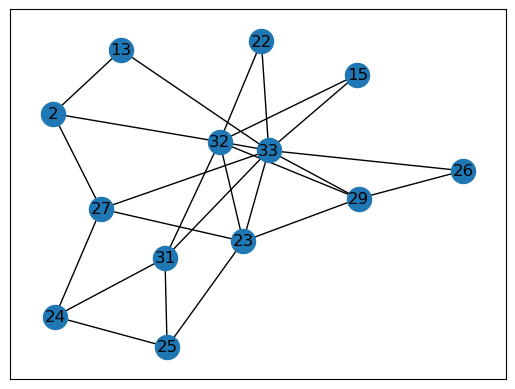

In [22]:
# Visualization of a random walk
# walk = randomWalk(6, 20)
print('Steps in random walk:', walks[0])

walk_graph = G.subgraph(walks[0])
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap=plt.get_cmap('cool'))
plt.show()

In [23]:
# Training the Word2Vec model
model = Word2Vec(walks, vector_size=128, window=5, min_count=1, sg=1, hs=1, workers=2, epochs=10)
embeddings = model.wv.vectors
embeddings.shape

(34, 128)

In [12]:
def biasedRandomWalk(start_node, walk_length, p, q):
    walk = [start_node]
    for i in range(walk_length - 1):
        neighbors = np.array(data.edge_index[1][data.edge_index[0] == walk[-1]])
        if len(walk) == 1:
            walk.append(np.random.choice(neighbors))
        else:
            previous_node_neighbors = data.edge_index[1][data.edge_index[0] == walk[-2]]
            probability = np.array([1/q] * len(neighbors), dtype=float)
            probability[neighbors == walk[-2]] = 1/p
            probability[(np.isin(neighbors, previous_node_neighbors))] = 1
            probability = probability / np.sum(probability)
            walk.append(np.random.choice(neighbors, 1, p=probability)[0])

    return walk

In [13]:
walk_number = 10 # Number of walks performed per vertex
walk_length = 20
vertices = np.arange(data.num_nodes)
walks = []
for i in range(walk_number):
    np.random.shuffle(vertices) 
    for j in vertices:
        walks.append(biasedRandomWalk(j, walk_length, 10, 0.1))

Steps in random walk: [3, 12, 0, 13, 2, 7, 1, 13, 33, 31, 0, 6, 16, 5, 0, 19, 1, 7, 2, 32]


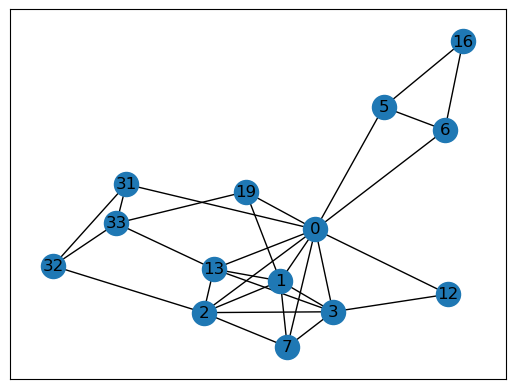

In [14]:
# Visualization of a biased random walk

print('Steps in random walk:', walks[0])

walk_graph = G.subgraph(walks[0])
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap=plt.get_cmap('cool'))
plt.show()

In [17]:
# Training the Word2Vec model
model = Word2Vec(walks, vector_size=128, window=5, min_count=1, sg=1, hs=1, workers=2, epochs=10)
embeddings = model.wv.vectors
embeddings.shape

(34, 128)